In [ ]:
from src.files.blast import BLASTJsonFile
from src.files.fasta import FASTAFile, get_reverse_complement
import re
import os 
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
from src.download import *
from src.stop_codon import *

Entrez.email = 'prichter@berkeley.edu'

In [ ]:
def parse_coordinates(coords:str):
    coords = coords.replace('&lt;', '<').replace('&gt;', '>')
    match = re.search(r'([\d<>]+)\.\.([\d<>]+)', coords)
    strand = '-' if 'complement' in coords else '+'

    coords = [match.group(1), match.group(2)]

    partial = ['0', '0']
    for i, coord in enumerate(coords):
        if ('<' in coord) or ('>' in coord):
            partial[i] = '1'
            coords[i] = coord.replace('<', '').replace('>', '')

    start, stop = coords
    return start, stop, strand, ''.join(partial)


def remove_nuccore_duplicates(arf12_df:pd.DataFrame):
    get_nuccore_id = lambda nuccore_id : nuccore_id.replace('NZ_', '').replace('_', '').split('.')[0]
    is_reference = lambda nuccore_id : nuccore_id.startswith('NZ_')
    
    arf12_df['reference'] = arf12_df.nuccore_id.apply(is_reference)
    arf12_df = arf12_df.sort_values('reference', ascending=False) # Sort so that the reference sequences are first. 
    arf12_df['nuccore_id_'] = arf12_df.nuccore_id.apply(get_nuccore_id)
    arf12_df = arf12_df.drop_duplicates('nuccore_id_')
    print('remove_nuccore_duplicates: Num. sequences derived from unique nuccore entries:', len(arf12_df))
    return arf12_df 


In [5]:
blast_df = BLASTJsonFile('../data/arf1-2.json').to_df()
blast_df = blast_df.drop_duplicates('subject_id')
print('Num. BLAST hits:', len(blast_df))

Num. BLAST hits: 549


In [ ]:
if not os.path.exists('../data/arf1-2.csv'):
    arf12_df = list()
    for id_ in tqdm(blast_df.subject_id, desc='Downloading aRF1-2 sequences...'):
        if id_.startswith('WP'):
            arf12_df += download_nr_protein_info(id_)
        else:
            arf12_df += [download_protein_info(id_)]

    arf12_df = pd.DataFrame(arf12_df).set_index('id')
    arf12_df.to_csv('../data/arf1-2.csv')


In [ ]:
# Go through the ones with string coordinates and parse them all. 
for row in arf12_df[~arf12_df.coordinates.isnull()].itertuples():
    
    start, stop, strand, partial = parse_coordinates(row.coordinates)
    arf12_df.loc[row.Index, 'start'] = int(start)
    arf12_df.loc[row.Index, 'stop'] = int(stop)
    arf12_df.loc[row.Index, 'strand'] = strand 
    arf12_df.loc[row.Index, 'partial'] = partial


In [ ]:
arf12_df = pd.read_csv('../data/arf1-2.csv', index_col=0)
arf12_df = arf12_df[~arf12_df.nuccore_id.isnull()].copy()
arf12_df = arf12_df.merge(blast_df.set_index('subject_id'), left_index=True, right_index=True)
arf12_df = arf12_df.rename(columns={'subject_seq':'seq'})
arf12_df = remove_nuccore_duplicates(arf12_df.copy())

remove_nuccore_duplicates: Num. sequences derived from unique nuccore entries: 769


In [10]:
nt_seqs = list()
for row in tqdm(list(arf12_df.itertuples()), desc='Loading nucleotide sequences from FASTA files.'):
    fasta_file = FASTAFile().from_fasta(row.fn_path)
    nt_seq = fasta_file.get_seq(row.nuccore_id, start=int(row.start) - 1, stop=int(row.stop))
    nt_seq = get_reverse_complement(nt_seq) if (row.strand == '-') else nt_seq
    nt_seqs += [nt_seq]
    
arf12_df['nt_seq'] = nt_seqs
arf12_df['stop_codon'] = arf12_df.nt_seq.str.slice(start=-3)
arf12_df['genus'] = arf12_df.organism.apply(lambda org : org.replace('Candidatus', '').split()[0])
arf12_df = arf12_df[arf12_df.stop_codon.isin(['TAG', 'TGA', 'TAA'])].copy() # Ones without valid stop codons are likely partial.

Loading nucleotide sequences from FASTA files.: 100%|██████████| 769/769 [00:06<00:00, 120.77it/s]


In [ ]:


if 'assembly_id' not in arf12_df.columns:
    arf12_df['assembly_id'] = [download_assembly_id(nuccore_id) for nuccore_id in tqdm(arf12_df.nuccore_id, desc='Downloading assembly IDs from NCBI.')]


from src.tools import run_prodigal

run_prodigal()

run_prodigal:  92%|█████████▏| 5221/5690 [39:23<05:10,  1.51it/s]  

In [ ]:
build_stop_codon_genome_metadata_dataset(genome_ids:list, fn_dir:str='../dta/ncbi/genomes', fa_dir:str='../data/prodigal', path:str=None)

In [ ]:
arf12_df.to_csv('../data/arf1-2_cleaned.csv')

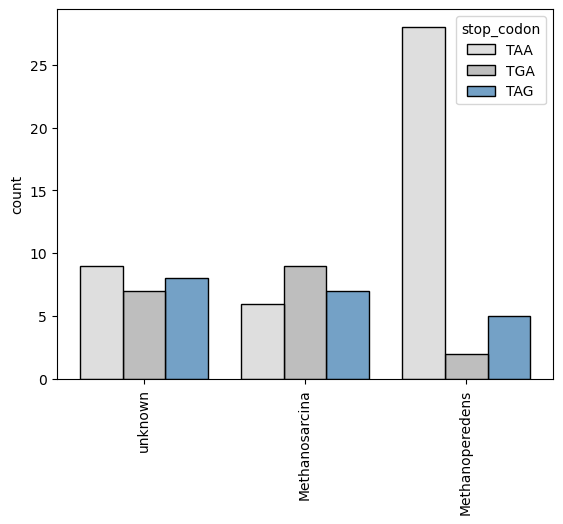

In [ ]:
arf12_df['methanosarcinales'] = arf12_df.genus.str.contains('Methanosarcinales', case=False) | arf12_df.taxonomy.str.contains('Methanosarcinales', case=False)
arf12_df = arf12_df[arf12_df.methanosarcinales].copy()
arf12_df['genus'] = np.where(arf12_df.genus == 'Methanosarcinales', 'unknown', arf12_df.genus)

palette = {'TAG':'steelblue', 'TGA':'darkgray', 'TAA':'lightgray'}

genus_counts = arf12_df.genus.value_counts()

fig, ax = plt.subplots()

figure_df = arf12_df.copy()
figure_df = figure_df[figure_df.genus.isin(genus_counts[genus_counts > 20].index.values)].copy()

sns.histplot(figure_df, ax=ax, x='genus', hue='stop_codon', palette=palette, multiple='dodge', shrink=0.8, stat='count', common_norm=True)
ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
# ax.set_ylabel('fraction of total')
ax.set_ylabel('count')

# heights = np.array([p.get_height() for p in ax.patches])
# heights = heights / heights.max()
# for p, h in zip(ax.patches, heights):
#     p.set_height(h)
# ax.set_ylim(ymin=0, ymax=1.01)

plt.show()

In [ ]:
arf12_df.nt_seq.str.slice(start=-3)

id
WP_048123334    TGA
WP_048037734    TGA
WP_278098996    TAA
WP_324330307    TGA
WP_338096253    TAA
               ... 
WP_013036486    TAA
WP_013036486    TAA
MDW7732995      TGA
WP_072561087    TAA
RLG21017        TGG
Name: nt_seq, Length: 769, dtype: object

In [ ]:
# def download_protein_info(id_, fn_dir:str='../data/ncbi/nucleotides'):
    
#     info = list()
    
    # result = Entrez.esearch(db='protein', term=id_, rettype='html').read().decode('utf-8')
    # protein_ids = get_ids(result)
    # if len(protein_ids) == 0:
    #     print(f'download_protein_info: No results for {id_}')
    #     return info
    
#     for protein_id in protein_ids:
#         info = {'id':id_, 'numerical_protein_id':protein_id}
    
#         result = Entrez.efetch(db='protein', id=protein_id, rettype='html').read().decode('utf-8')
#         info['nuccore_id'], info['coordinates'] = get_coordinates(result)
        
#         result = Entrez.elink(dbfrom='protein', db='nuccore', id=protein_id, rettype='html').read().decode('utf-8')
#         nuccore_id = get_ids(result)
#         if len(nuccore_id) == 0:
#             info.append(info)
#             continue 
#         else:
#             nuccore_id = nuccore_id[1] # First ID tag is just the ID itself. 

#         result = Entrez.efetch(db='nuccore', id=nuccore_id, rettype='html').read().decode('utf-8')

#         info['organism'] = get_organism(result)
#         info['taxonomy'] = get_taxonomy(result)
#         # info['nuccore_id'] = get_nuccore_accession(result)
#         info['numerical_nuccore_id'] = nuccore_id

#         fn_path = os.path.join(fn_dir, f'{nuccore_id}.fn')
#         if not os.path.exists(fn_path):
#             result = Entrez.efetch(db='nuccore', id=nuccore_id, rettype='fasta').read()
#             with open(fn_path, 'w') as f:
#                 f.write(result)
#             info['fn_path'] = fn_path
#         info.append(info)
    
#     return info

# arf12_df = list()
# for id_ in tqdm(blast_df.subject_id, desc='Downloading aRF1-2 sequences...'):
#     arf12_df += download_protein_info(id_)
# arf12_df = pd.DataFrame(arf12_df).set_index('id')
